In [157]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# show all columns
pd.set_option('display.max_columns', None)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [159]:
%%R

install.packages("zoo")

R[write to console]: Installing package into ‘/usr/local/lib/R/4.3/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.ma.imperial.ac.uk/src/contrib/zoo_1.8-12.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 782344 bytes (764 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =

clang -I"/usr/local/Cellar/r/4.3.0_1/lib/R/include" -DNDEBUG -I../inst/include  -I/usr/local/opt/gettext/include -I/usr/local/opt/readline/include -I/usr/local/opt/xz/include -I/usr/local/include    -fPIC  -g -O2  -c coredata.c -o coredata.o
clang -I"/usr/local/Cellar/r/4.3.0_1/lib/R/include" -DNDEBUG -I../inst/include  -I/usr/local/opt/gettext/include -I/usr/local/opt/readline/include -I/usr/local/opt/xz/include -I/usr/local/include    -fPIC  -g -O2  -c init.c -o init.o
clang -I"/usr/local/Cellar/r/4.3.0_1/lib/R/include" -DNDEBUG -I../inst/include  -I/usr/local/opt/gettext/include -I/usr/local/opt/readline/include -I/usr/local/opt/xz/include -I/usr/local/include    -fPIC  -g -O2  -c lag.c -o lag.o
clang -dynamiclib -Wl,-headerpad_max_install_names -undefined dynamic_lookup -single_module -multiply_defined suppress -L/usr/local/Cellar/r/4.3.0_1/lib/R/lib -L/usr/local/opt/gettext/lib -L/usr/local/opt/readline/lib -L/usr/local/opt/xz/lib -L/usr/local/lib -o zoo.so coredata.o init.o lag.o

installing to /usr/local/lib/R/4.3/site-library/00LOCK-zoo/00new/zoo/libs
** R
** demo
** inst
** byte-compile and prepare package for lazy loading


During startup - Warning messages:
1: Setting LC_TIME failed, using "C" 
2: Setting LC_MESSAGES failed, using "C" 
3: Setting LC_MONETARY failed, using "C" 


** help
*** installing help indices
** building package indices


During startup - Warning messages:
1: Setting LC_TIME failed, using "C" 
2: Setting LC_MESSAGES failed, using "C" 
3: Setting LC_MONETARY failed, using "C" 


** installing vignettes
** testing if installed package can be loaded from temporary location


During startup - Warning messages:
1: Setting LC_TIME failed, using "C" 
2: Setting LC_MESSAGES failed, using "C" 
3: Setting LC_MONETARY failed, using "C" 


** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (zoo)
R[write to console]: 

R[write to console]: 
R[write to console]: The downloaded source packages are in
	‘/private/var/folders/0n/lrk8qbzx5957h5wbrqq_707m0000gn/T/RtmpfOxYxH/downloaded_packages’
R[write to console]: 
R[write to console]: 



During startup - Warning messages:
1: Setting LC_TIME failed, using "C" 
2: Setting LC_MESSAGES failed, using "C" 
3: Setting LC_MONETARY failed, using "C" 


In [160]:
%%R 

require('tidyverse')
require('tidyr')
require('stringr')
require('zoo')
require('dplyr')


# Load and clean data

In [167]:
# Load data

points = pd.read_csv('points.csv')
display(points.head(5))

fees = pd.read_csv('fees.csv')
display(fees.head(5))



,Squad,Pts_2023,Pts_2022,Pts_2021,Pts_2020,Pts_2019,Pts_2018,Pts_2017,Pts_2016,Pts_2015,Pts_2014,Pts_2013,Pts_2012,Pts_2011,Pts_2010,Pts_2009,Pts_2008,Pts_2007,Pts_2006,Pts_2005,Pts_2004,Pts_2003,Pts_2002,Pts_2001,Pts_2000,Pts_1999,Pts_1998,Pts_1997,Pts_1996,Pts_1995,Pts_1994,Pts_1993,Pts_1992,Total_Pts
0,Arsenal,81.0,69.0,61.0,56.0,70.0,63.0,75.0,71.0,75.0,79.0,73.0,70.0,68.0,75.0,72.0,83.0,68.0,67.0,83.0,90.0,78.0,87.0,70.0,73.0,78.0,78.0,68.0,63.0,51.0,71.0,56.0,72.0,2294.0
1,Aston Villa,54.0,45.0,55.0,35.0,NaN,NaN,NaN,17.0,38.0,38.0,41.0,38.0,48.0,64.0,62.0,60.0,50.0,42.0,47.0,56.0,45.0,50.0,54.0,58.0,55.0,57.0,61.0,63.0,48.0,57.0,74.0,60.0,1472.0
2,Bournemouth,39.0,NaN,NaN,34.0,45.0,44.0,46.0,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250.0
3,Brentford,50.0,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.0
4,Brighton,55.0,51.0,41.0,41.0,36.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.0


,club_name,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AFC Bournemouth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.055,4.82,55.11,40.690,34.300,91.60,54.91,0.00,12.64,83.10
1,Arsenal,4.60,1.28,7.18,18.350,6.11,22.025,15.95,25.4,56.30,32.685,12.830,27.425,12.48,46.00,15.000,30.95,40.15,12.00,23.00,65.480,56.00,49.250,118.98,26.50,113.000,152.850,80.15,160.80,86.00,167.40,192.36
2,Aston Villa,3.93,4.25,7.34,11.067,8.10,10.500,42.80,9.6,21.12,26.100,9.080,8.380,10.14,16.54,24.700,24.90,55.90,46.90,37.40,20.335,27.83,19.840,13.45,66.55,85.500,2.800,19.10,159.50,101.35,129.80,100.14
3,Barnsley,NaN,NaN,NaN,NaN,NaN,6.937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.625,3.84,2.34,2.34,2.71,1.290,0.00,0.545,NaN,NaN,2.540,6.385,NaN,6.35,3.00,1.20,NaN
4,Birmingham City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.685,17.100,15.77,8.10,20.430,29.30,3.50,20.05,25.60,0.570,0.32,0.000,0.00,3.04,10.085,17.650,2.50,10.28,8.34,0.00,0.00


In [178]:
%%R -i points,fees

# pivot longer

points <- points %>% 
    pivot_longer(cols=-Squad, names_to='year', values_to='points') %>% 
    mutate(year = as.integer(str_replace(year, 'Pts_', ''))) %>%
    mutate(Squad = str_replace(Squad, 'Nott\'ham Forest', 'Nottingham Forest')) 


fees <- fees %>% 
  pivot_longer(cols = -club_name, values_to='fees') %>% 
  mutate(year = as.integer(name)) %>% 
  select(-name) %>% # drops name column
  mutate(club_name = str_replace_all(club_name, c('AFC ' = '', 
                                                  ' AFC' = '',
                                                    ' & Hove Albion' = '', 
                                                    'Huddersfield Town' = 'Huddersfield', 
                                                    'Tottenham Hotspur' = 'Tottenham',
                                                    'Blackburn Rovers' = 'Blackburn',
                                                    'West Bromwich Albion' = 'West Brom', 
                                                    'West Ham United' = 'West Ham')))



In [179]:
%%R -o points_clubs,fees_clubs
points_clubs <- points %>% select(Squad)  %>% arrange(Squad) %>% unique()
fees_clubs <- fees %>% select(club_name) %>% arrange(club_name) %>% unique()


In [180]:
# Note, these exist in points and note fees, that's because they were relegated
set(points_clubs.Squad.unique()) - set(fees_clubs.club_name.unique())

{'Charlton Ath', 'Notts County'}

In [181]:
# no clubs in fees but not points
set(fees_clubs.club_name.unique()) - set(points_clubs.Squad.unique())

set()

In [182]:
fees.club_name.unique()

array(['AFC Bournemouth', 'Arsenal', 'Aston Villa', 'Barnsley',
       'Birmingham City', 'Blackburn Rovers', 'Blackpool',
       'Bolton Wanderers', 'Bradford City', 'Brentford',
       'Brighton & Hove Albion', 'Burnley', 'Cardiff City', 'Chelsea',
       'Coventry City', 'Crystal Palace', 'Derby County', 'Everton',
       'Fulham', 'Huddersfield Town', 'Hull City', 'Ipswich Town',
       'Leeds United', 'Leicester City', 'Liverpool', 'Luton Town',
       'Manchester City', 'Manchester United', 'Middlesbrough',
       'Newcastle United', 'Norwich City', 'Nottingham Forest',
       'Oldham Athletic', 'Portsmouth', 'Queens Park Rangers', 'Reading',
       'Sheffield United', 'Sheffield Wednesday', 'Southampton',
       'Stoke City', 'Sunderland AFC', 'Swansea City', 'Swindon Town',
       'Tottenham Hotspur', 'Watford', 'West Bromwich Albion',
       'West Ham United', 'Wigan Athletic', 'Wimbledon',
       'Wolverhampton Wanderers'], dtype=object)

In [173]:
points.Squad.unique()

array(['Arsenal', 'Aston Villa', 'Bournemouth', 'Brentford', 'Brighton',
       'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Leeds United',
       'Leicester City', 'Liverpool', 'Manchester City',
       'Manchester United', 'Newcastle United', 'Nottingham Forest',
       'Southampton', 'Tottenham', 'West Ham', 'Wolverhampton Wanderers',
       'Burnley', 'Norwich City', 'Watford', 'Sheffield United',
       'West Brom', 'Cardiff City', 'Huddersfield', 'Stoke City',
       'Swansea City', 'Hull City', 'Middlesbrough', 'Sunderland',
       'Queens Park Rangers', 'Reading', 'Wigan Athletic', 'Blackburn',
       'Bolton Wanderers', 'Birmingham City', 'Blackpool', 'Portsmouth',
       'Derby County', 'Charlton Ath', 'Ipswich Town', 'Bradford City',
       'Coventry City', 'Sheffield Wednesday', 'Wimbledon', 'Barnsley',
       'Oldham Athletic', 'Swindon Town', 'Luton Town', 'Notts County'],
      dtype=object)

## Join

In [174]:
%%R -o df

# merge fees and points on club_name and Squad respectively
df <- fees %>% merge(points, by.x = c('club_name','year'), by.y = c('Squad','year')) 
df %>% head()


  club_name year   fees points
1   Arsenal 1992  4.600     72
2   Arsenal 1993  1.280     56
3   Arsenal 1994  7.180     71
4   Arsenal 1995 18.350     51
5   Arsenal 1996  6.110     63
6   Arsenal 1997 22.025     68


# Analysis

In [187]:
%%R -o df

# TODO  - make sure that if a year is mising, it is rollmeanr is dividing by 3 and not 4
# calculate a column that is fees from the last 4 years of a club
df <- df %>% 
    group_by(club_name) %>%
    mutate(
        fees_4 = rollsumr(fees, 4, fill = NA),
        points_4_avg = rollmeanr(points, 4, fill = NA)
    ) %>%
    ungroup() %>% 
    filter(year > 1992)

df

# A tibble: 1,250 × 6
   club_name  year  fees points fees_4 points_4_avg
   <chr>     <int> <dbl>  <dbl>  <dbl>        <dbl>
 1 Arsenal    1998  16.0     78   NA           NA  
 2 Arsenal    1999  25.4     78   NA           NA  
 3 Arsenal    2000  56.3     73   NA           NA  
 4 Arsenal    2001  32.7     70  130.          74.8
 5 Arsenal    2002  12.8     87  127.          77  
 6 Arsenal    2003  27.4     78  129.          77  
 7 Arsenal    2004  12.5     90   85.4         81.2
 8 Arsenal    2005  46       83   98.7         84.5
 9 Arsenal    2006  15       67  101.          79.5
10 Arsenal    2007  31.0     68  104.          77  
# ℹ 1,240 more rows
# ℹ Use `print(n = ...)` to see more rows


In [184]:
df

,club_name,year,fees,points,fees_4,points_4_avg
1,Arsenal,1998,15.950,78.0,NaN,NaN
2,Arsenal,1999,25.400,78.0,NaN,NaN
3,Arsenal,2000,56.300,73.0,NaN,NaN
4,Arsenal,2001,32.685,70.0,130.335,74.75
5,Arsenal,2002,12.830,87.0,127.215,77.00
...,...,...,...,...,...,...
1246,Wolverhampton Wanderers,2018,112.750,NaN,182.804,NaN
1247,Wolverhampton Wanderers,2019,116.700,57.0,290.160,NaN
1248,Wolverhampton Wanderers,2020,87.589,59.0,341.649,NaN
1249,Wolverhampton Wanderers,2021,37.600,45.0,354.639,NaN


`geom_smooth()` using formula = 'y ~ x'


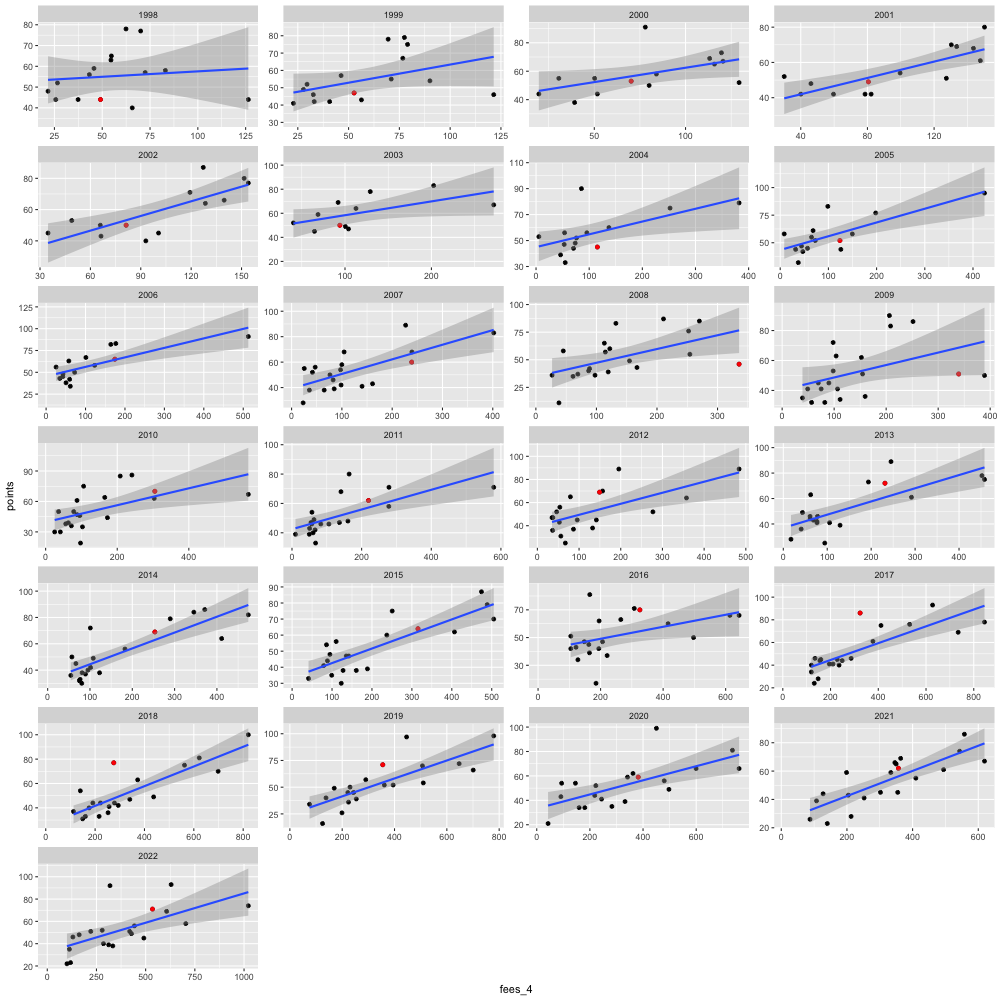

In [176]:
%%R -w 1000 -h 1000
# Exploratory data analysis

ggplot(df) +
    aes(x=fees_4, y=points) +
    geom_point() +
    geom_point(data = df %>% filter(club_name == "Tottenham"), color='red') +
    geom_smooth(method='lm') +
    facet_wrap(~year, ncol=4, scales='free') 


In [ ]:
%%R
# Exploratory data analysis


In [177]:
# To do next

- run regressions for each year y=points_4_avg , x=fees_4
- look at r^2 of those for each year and p-values
- residuals for each club over time


SyntaxError: invalid syntax (2142448683.py, line 3)